In [52]:
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.utils import layer_utils
# from quiver_engine import server
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform


In [53]:
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [54]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [55]:
print("train x",x_train.shape)
print("train y",y_train.shape)
print("test x",x_test.shape)
print("test y",y_test.shape)

train x (50000, 32, 32, 3)
train y (50000, 1)
test x (10000, 32, 32, 3)
test y (10000, 1)


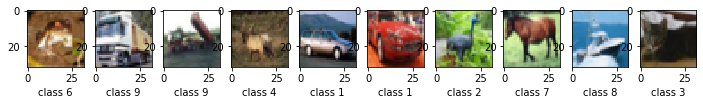

Label Encodings:
Airplane    -> 0
Automobile  -> 1
Bird        -> 2
Cat         -> 3
Deer        -> 4
Dog         -> 5
Frog        -> 6
Horse       -> 7
Ship        -> 8
Truck       -> 9


In [56]:
plt.figure(figsize=(12,10))
x, y = 10, 1
for i in range(0,10):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((32,32,3)),interpolation='nearest',cmap='Greys')
    plt.xlabel('class %d' %y_train[i])
plt.show()
print("Label Encodings:")
print("Airplane    -> 0")
print("Automobile  -> 1")
print("Bird        -> 2")
print("Cat         -> 3")
print("Deer        -> 4")
print("Dog         -> 5")
print("Frog        -> 6")
print("Horse       -> 7")
print("Ship        -> 8")
print("Truck       -> 9")

Text(0.5, 1.0, 'Test Class')

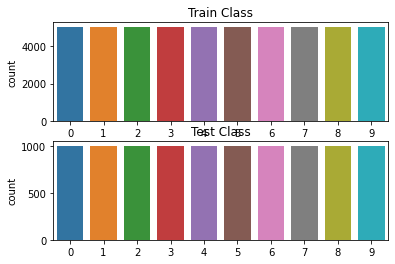

In [57]:
#plotting output class
fig=plt.figure()
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)
sns.countplot(y_train.flatten(),ax=ax1).set_title('Train Class')
sns.countplot(y_test.flatten(),ax=ax2).set_title('Test Class')

In [58]:
y_train= to_categorical(y_train,10)
y_test=to_categorical(y_test,10)

In [59]:
def basic_normal(inputs,stride,filters):
  f1,f2=filters
  
  inputs=Conv2D(filters=f1,kernel_size=(3,3),strides=(stride,stride),padding='same',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  
  inputs=Conv2D(filters=f2,kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  
  return (inputs)
  

In [60]:
def basic_proactivations(inputs,stride,filters,is_first_layer):
  f1,f2=filters
  if (is_first_layer ==False):
    inputs=BatchNormalization(axis=3)(inputs)
    inputs=Activation('relu')(inputs)
  inputs=Conv2D(filters=f1,kernel_size=(3,3),strides=(stride,stride),padding='same',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
 
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  inputs=Conv2D(filters=f2,kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
 
  return (inputs)

In [61]:
def bottleneck_normal(inputs,stride,filters):
  f1,f2,f3=filters
  
  inputs=Conv2D(filters=f1,kernel_size=(1,1),strides=(stride,stride),padding='valid',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  
  inputs=Conv2D(filters=f2,kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  
  inputs=Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  
  return (inputs)

In [62]:
def bottleneck_proactivations(inputs,stride,filters,is_first_layer):
  f1,f2,f3=filters
  if (is_first_layer ==False):
    inputs=BatchNormalization(axis=3)(inputs)
    inputs=Activation('relu')(inputs)
  inputs=Conv2D(filters=f1,kernel_size=(1,1),strides=(stride,stride),padding='valid',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
 
  
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  inputs=Conv2D(filters=f2,kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
 
  
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  inputs=Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
 
  return (inputs)

In [63]:
def convolution_block(inputs,stride,filters,proactivation,network_type,is_first_layer):
  
  f3=filters[-1]
  
  if (network_type==2):
    if (proactivation==False):
      output=bottleneck_normal(inputs,stride,filters)
    else:
      output=bottleneck_proactivations(inputs,stride,filters,is_first_layer)
  else:
    if (proactivation==False):
      output=basic_normal(inputs,stride,filters)
    else:
      output=basic_proactivations(inputs,stride,filters,is_first_layer)
      
  inputs=Conv2D(filters=f3,kernel_size=(1,1),strides=(stride,stride),padding='valid',kernel_initializer=glorot_uniform(seed=0),dilation_rate=(1,1),kernel_regularizer=None)(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  
  inputs=Add()([inputs,output])
  inputs=Activation('relu')(inputs)
  
  return(inputs)

In [64]:
def identity_block(inputs,filters,network_type,proactivation):
 
  stride=1
  
  if (network_type==2):
    if (proactivation==False):
      output=bottleneck_normal(inputs,stride,filters)
    else:
      output=bottleneck_proactivations(inputs,stride,filters,False)
  else:
    if (proactivation==False):
      output=basic_normal(inputs,stride,filters)
    else:
      output=basic_proactivations(inputs,stride,filters,False)

  
  inputs=Add()([inputs,output])
  inputs=Activation('relu')(inputs)
  
  return(inputs)

In [65]:
def Layers(repetition,inputs,stride,filters,proactivation,network_type,is_first_layer):
  layer=convolution_block(inputs,stride,filters,proactivation,network_type,is_first_layer)
  for i in range(repetition-1):
    layer=identity_block(layer,filters,network_type,proactivation)
    
  return layer

In [66]:
def resnet50(inp_shape,no_of_classes,proactivation):
  r1,r2,r3,r4=[3,4,6,3]
  network_type=2
  input_data=Input(inp_shape)
  inputs=ZeroPadding2D((3, 3))(input_data)
  inputs=Conv2D(64,(7,7),strides=(2,2),kernel_initializer=glorot_uniform(seed=0))(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  inputs=MaxPooling2D((3, 3), strides=(2, 2))(inputs)
  layer_1=Layers(r1,inputs,1,[64,64,256],proactivation,network_type,is_first_layer=True)
  layer_2=Layers(r2,layer_1,2,[128,128,512],proactivation,network_type,is_first_layer=False)
  layer_3=Layers(r3,layer_2,2,[256,256,1024],proactivation,network_type,is_first_layer=False)
  layer_4=Layers(r4,layer_3,2,[512,512,2048],proactivation,network_type,is_first_layer=False)
  output_1=AveragePooling2D(pool_size=(2,2), padding='same')(layer_4)
  output_2=Flatten()(output_1)
  final_out=Dense(no_of_classes,activation='softmax', kernel_initializer=glorot_uniform(seed=0))(output_2)
  model =Model(inputs=input_data,outputs=final_out)
  return(model)

In [67]:
def resnet101(inp_shape,no_of_classes,proactivation):
  r1,r2,r3,r4=[3,4,23,3]
  network_type=2
  input_data=Input(inp_shape)
  inputs=ZeroPadding2D((3, 3))(input_data)
  inputs=Conv2D(64,(7,7),strides=(2,2),kernel_initializer=glorot_uniform(seed=0))(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  inputs=MaxPooling2D((3, 3), strides=(2, 2))(inputs)
  layer_1=Layers(r1,inputs,1,[64,64,256],proactivation,network_type,is_first_layer=True)
  layer_2=Layers(r2,layer_1,2,[128,128,512],proactivation,network_type,is_first_layer=False)
  layer_3=Layers(r3,layer_2,2,[256,256,1024],proactivation,network_type,is_first_layer=False)
  layer_4=Layers(r4,layer_3,2,[512,512,2048],proactivation,network_type,is_first_layer=False)
  output_1=AveragePooling2D(pool_size=(2,2), padding='same')(layer_4)
  output_2=Flatten()(output_1)
  final_out=Dense(no_of_classes,activation='softmax', kernel_initializer=glorot_uniform(seed=0))(output_2)
  model =Model(inputs=input_data,outputs=final_out)
  return(model)

In [68]:
def resnet152(inp_shape,no_of_classes,proactivation):
  r1,r2,r3,r4=[3,8,36,3]
  network_type=2
  input_data=Input(inp_shape)
  inputs=ZeroPadding2D((3, 3))(input_data)
  inputs=Conv2D(64,(7,7),strides=(2,2),kernel_initializer=glorot_uniform(seed=0))(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  inputs=MaxPooling2D((3, 3), strides=(2, 2))(inputs)
  layer_1=Layers(r1,inputs,1,[64,64,256],proactivation,network_type,is_first_layer=True)
  layer_2=Layers(r2,layer_1,2,[128,128,512],proactivation,network_type,is_first_layer=False)
  layer_3=Layers(r3,layer_2,2,[256,256,1024],proactivation,network_type,is_first_layer=False)
  layer_4=Layers(r4,layer_3,2,[512,512,2048],proactivation,network_type,is_first_layer=False)
  output_1=AveragePooling2D(pool_size=(2,2), padding='same')(layer_4)
  output_2=Flatten()(output_1)
  final_out=Dense(no_of_classes,activation='softmax', kernel_initializer=glorot_uniform(seed=0))(output_2)
  model =Model(inputs=input_data,outputs=final_out)
  return(model)

In [69]:
def resnet18(inp_shape,no_of_classes,proactivation):
  r1,r2,r3,r4=[2,2,2,2]
  network_type=1
  input_data=Input(inp_shape)
  inputs=ZeroPadding2D((3, 3))(input_data)
  inputs=Conv2D(64,(7,7),strides=(2,2),kernel_initializer=glorot_uniform(seed=0))(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  inputs=MaxPooling2D((3, 3), strides=(2, 2))(inputs)
  layer_1=Layers(r1,inputs,1,[64,64],proactivation,network_type,is_first_layer=True)
  layer_2=Layers(r2,layer_1,2,[128,128],proactivation,network_type,is_first_layer=False)
  layer_3=Layers(r3,layer_2,2,[256,256],proactivation,network_type,is_first_layer=False)
  layer_4=Layers(r4,layer_3,2,[512,512],proactivation,network_type,is_first_layer=False)
  output_1=AveragePooling2D(pool_size=(2,2), padding='same')(layer_4)
  output_2=Flatten()(output_1)
  final_out=Dense(no_of_classes,activation='softmax', kernel_initializer=glorot_uniform(seed=0))(output_2)
  model =Model(inputs=input_data,outputs=final_out)
  return(model)

In [70]:
def resnet34(inp_shape,no_of_classes,proactivation):
  r1,r2,r3,r4=[3,4,6,3]
  network_type=1
  input_data=Input(inp_shape)
  inputs=ZeroPadding2D((3, 3))(input_data)
  inputs=Conv2D(64,(7,7),strides=(2,2),kernel_initializer=glorot_uniform(seed=0))(inputs)
  inputs=BatchNormalization(axis=3)(inputs)
  inputs=Activation('relu')(inputs)
  inputs=MaxPooling2D((3, 3), strides=(2, 2))(inputs)
  layer_1=Layers(r1,inputs,1,[64,64],proactivation,network_type,is_first_layer=True)
  layer_2=Layers(r2,layer_1,2,[128,128],proactivation,network_type,is_first_layer=False)
  layer_3=Layers(r3,layer_2,2,[256,256],proactivation,network_type,is_first_layer=False)
  layer_4=Layers(r4,layer_3,2,[512,512],proactivation,network_type,is_first_layer=False)
  output_1=AveragePooling2D(pool_size=(2,2), padding='same')(layer_4)
  output_2=Flatten()(output_1)
  final_out=Dense(no_of_classes,activation='softmax', kernel_initializer=glorot_uniform(seed=0))(output_2)
  model =Model(inputs=input_data,outputs=final_out)
  return(model)

In [71]:
#hyperparameter
proactivation=False

In [72]:
#residual network ->18 layers
model_18_layer= resnet18((32,32,3),10,proactivation)

In [73]:
#residual network ->34 layers
model_34_layer= resnet34((32,32,3),10,proactivation)

In [74]:
#residual network ->50 layers
model_50_layer= resnet50((32,32,3),10,proactivation)

In [75]:
#residual network ->101 layers
model_101_layer= resnet101((32,32,3),10,proactivation)

In [76]:
#residual network ->152 layers
model_152_layer= resnet152((32,32,3),10,proactivation)

In [77]:
model_18_layer.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 38, 38, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_465 (Conv2D)             (None, 16, 16, 64)   9472        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
batch_normalization_458 (BatchN (None, 16, 16, 64)   256         conv2d_465[0][0]                 
____________________________________________________________________________________________

In [78]:
model_18_layer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
checkpointer = ModelCheckpoint(filepath="C:/Users/JOSHIKAA/Desktop/joshikaa/best_weights.hdf5",  monitor = 'val_accuracy',
                               verbose=1, save_best_only=True, mode='max',save_weights_only=False)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#model_34_layer.load_weights('C:/Users/JOSHIKAA/Desktop/joshikaa/best_weights.hdf5')

In [80]:
model_18_layer.fit(x_train,y_train,epochs=15,batch_size=16,validation_split=0.20, callbacks=[checkpointer, es])

Epoch 1/15
2499/2500 [============================>.] - ETA: 0s - loss: 1.7319 - accuracy: 0.3970
Epoch 00001: val_accuracy improved from -inf to 0.44280, saving model to C:/Users/JOSHIKAA/Desktop/joshikaa/best_weights.hdf5
2500/2500 [==============================] - 72s 29ms/step - loss: 1.7316 - accuracy: 0.3971 - val_loss: 1.5330 - val_accuracy: 0.4428
Epoch 2/15
2499/2500 [============================>.] - ETA: 0s - loss: 1.3481 - accuracy: 0.5337
Epoch 00002: val_accuracy did not improve from 0.44280
2500/2500 [==============================] - 73s 29ms/step - loss: 1.3481 - accuracy: 0.5337 - val_loss: 2.0128 - val_accuracy: 0.4115
Epoch 3/15
2499/2500 [============================>.] - ETA: 0s - loss: 1.1172 - accuracy: 0.6137
Epoch 00003: val_accuracy improved from 0.44280 to 0.56860, saving model to C:/Users/JOSHIKAA/Desktop/joshikaa/best_weights.hdf5
2500/2500 [==============================] - 72s 29ms/step - loss: 1.1171 - accuracy: 0.6137 - val_loss: 1.2130 - val_accuracy

In [83]:
preds = model_18_layer.evaluate(x_test,y_test)
print("Loss in test data = " + str(preds[0]))
print("Accuracy in test data = " + str(preds[1]))

313/313 [==============================] - 3s 8ms/step - loss: 1.0032 - accuracy: 0.7226
Loss in test data = 1.0031685829162598
Accuracy in test data = 0.722599983215332
